# Demo: Fighting Overfitting with `nn.Dropout` and Learning Rate Decay

When training and validation performance diverge, your model is memorizing rather than learning. Can you fix overfitting without starting over? The answer is yes: dropout and learning rate scheduling can restore generalization and dramatically improve validation performance.

> **Overview**: Take an overfitting model and systematically improve it using two powerful regularization techniques: dropout (which forces the network to learn robust features) and learning rate scheduling (which helps the model converge more precisely).
> 
> **Scenario**: You're building a wine quality assessment platform for a distributor. They need to predict whether wines will be rated as "high quality" based on chemical properties like acidity, alcohol content, and sulfur dioxide levels. Your initial model works perfectly on training data, but fails on new wines. This is a classic overfitting problem that regularization can solve.
> 
> **Goal**: Understand how dropout and learning rate scheduling work together to prevent overfitting, and see the dramatic improvement they create in your validation performance.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Create output directory for visualizations
output_dir = 'assets/demo_model_improvements'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the data

We'll use the [mstz/wine](https://huggingface.co/datasets/mstz/wine) dataset from Hugging Face, which contains chemical analysis data for 6,497 wines from Portugal's Vinho Verde region.

For preprocessing, we'll:
1. _Load the dataset_
2. Create binary classification labels (high quality ≥7 vs. low quality <7)
3. Separate features and target variables
4. Normalize features using StandardScaler
5. Create PyTorch datasets and data loaders
6. Split into training (80%) and validation (20%) sets

In [2]:
# 1. Load the dataset
dataset = load_dataset('mstz/wine', split='train')
df = pd.DataFrame(dataset)

print(f"✓ Dataset loaded: {len(df)} wines")
print(f"✓ Features: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

✓ Dataset loaded: 6497 wines
✓ Features: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'is_red']

First few rows:
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.2

> **Why wine data reveals overfitting well**: With 12 correlated features (acidity types interact, sulfur compounds relate to preservation, alcohol affects density), this dataset has enough complexity for models to find spurious patterns. A model might memorize "high citric acid + low volatile acidity + 11.2% alcohol = quality 6" for specific training examples, rather than learning that balanced acidity profiles generally indicate quality. 
> 
> This makes it perfect for demonstrating how regularization forces real pattern learning.

In [3]:
# 2. Create binary classification labels
# High quality: score >= 7, Low quality: score < 7
df['high_quality'] = (df['quality'] >= 7).astype(int)

# Check class distribution
class_counts = df['high_quality'].value_counts()
print(f"\n✓ Binary classification created:")
print(f"   Low quality (0): {class_counts[0]} wines ({class_counts[0]/len(df)*100:.1f}%)")
print(f"   High quality (1): {class_counts[1]} wines ({class_counts[1]/len(df)*100:.1f}%)")


✓ Binary classification created:
   Low quality (0): 5220 wines (80.3%)
   High quality (1): 1277 wines (19.7%)


> **Why binary classification?** Converting quality scores (0-10) into binary labels (high vs. low quality) creates a focused classification task where overfitting patterns are easier to observe. 
> 
> With ~20% high-quality wines, the class imbalance also reflects real-world scenarios where regularization becomes even more critical. After all, models can easily "cheat" by memorizing the majority class.

In [4]:
# 3. Separate features and target
feature_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                   'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                   'pH', 'sulphates', 'alcohol', 'is_red']

X = df[feature_columns].values.astype(np.float32)
y = df['high_quality'].values.astype(np.float32)

# 4. Normalize features (important for neural networks!)
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"\n✓ Features normalized to zero mean and unit variance")
print(f"✓ Final dataset shape: {X.shape}")


✓ Features normalized to zero mean and unit variance
✓ Final dataset shape: (6497, 12)


> **How standardization clarifies overfitting dynamics**: Without standardizing features, the model might rely too heavily on high-magnitude features (like total sulfur dioxide at 0-300 range) while ignoring smaller ones (like pH at 2.5-4.0 range). This creates an illusion of learning when the model is actually just memorizing scale patterns. 
> 
> Standardization (zero mean, unit variance) ensures all features contribute fairly, making genuine overfitting (not scale artifacts) visible in our experiments.


In [5]:
# 5. Create train and validation splits with stratification to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Create PyTorch dataset
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and split into train/validation
train_dataset = WineDataset(X_train, y_train)
val_dataset = WineDataset(X_val, y_val)

> **Why a custom Dataset class?** While we could use `TensorDataset` for this simple case, creating a custom [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class is a best practice that pays off when fighting overfitting. Once you diagnose overfitting, you may want to add data augmentation (for images: rotations, crops; for tabular data: noise injection, mixup). 
>
> With a custom Dataset, you can easily add augmentation logic to `__getitem__` without restructuring your code. It's the foundation for the full overfitting toolkit: regularization in the model, augmentation in the data.

In [6]:
# 6. Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")
print(f"✓ Batch size: {batch_size}")

✓ Training samples: 5197
✓ Validation samples: 1300
✓ Batch size: 64


> **Batch size and overfitting**: Batch size affects generalization: smaller batches (16-32) add noise to gradients which acts as implicit regularization, while larger batches (256+) give stable gradients but may overfit more. 
> 
> We use `64` as a practical middle ground: stable enough for consistent training, small enough to provide some regularization benefit, and efficient for most GPUs.

## Step 3: Build the baseline model (without regularization)

Let's start with a simple feedforward neural network with NO regularization. This will be our baseline, and we'll intentionally let it overfit so we can see the dramatic improvement when we add dropout and learning rate scheduling.

In [7]:
# Baseline model WITHOUT regularization
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BaselineModel, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))  
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create baseline model
input_size = X.shape[1]  # 12 features
hidden_sizes = [128, 64, 32]  # Three hidden layers
output_size = 1  # Binary classification

baseline_model = BaselineModel(input_size, hidden_sizes, output_size).to(device)
print("✓ Baseline model created (NO regularization)")
print(f"  Architecture: {input_size} → 128 → 64 → 32 → {output_size}")
print(f"  Total parameters: {sum(p.numel() for p in baseline_model.parameters())}")

✓ Baseline model created (NO regularization)
  Architecture: 12 → 128 → 64 → 32 → 1
  Total parameters: 12033


> **Why this architecture will overfit**: With 128 → 64 → 32 hidden units across three layers, this network has over 12,000 trainable parameters for just 5,197 training examples, which is more than 2 parameters per sample. 
> 
> This high capacity gives the model plenty of room to memorize individual training examples rather than learning generalizable patterns. 


## Step 4: Train the baseline model and observe overfitting

Now let's train this baseline model and watch what happens. We'll track both training and validation loss to see the overfitting gap emerge.

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, 
                epochs=50, scheduler=None, model_name="Model"):
    """
    Train a model and track training/validation metrics.
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predictions = (outputs > 0.0).float()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = (outputs > 0.0).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | LR: {lr:.6f}")
    
    return train_losses, val_losses, train_accs, val_accs

baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

print("✓ Training function defined, with criterion and optimizer")

✓ Training function defined, with criterion and optimizer


> **Why Adam doesn’t prevent overfitting:** Adam adapts learning rates per parameter and uses momentum to stabilize updates, allowing the model to fit the training data quickly and reliably with minimal tuning. But optimization efficiency isn’t the same as generalization. 
> 
> Adam will happily minimize the training loss even when the model begins to memorize, so overfitting still occurs unless we add regularization, limit model capacity, or use more data. 

In [9]:
# Train baseline model
print("Training baseline model (no regularization)...\n")
epochs = 100

baseline_train_losses, baseline_val_losses, baseline_train_accs, baseline_val_accs = train_model(
    baseline_model, train_loader, val_loader, baseline_optimizer, criterion, 
    epochs=epochs, model_name="Baseline"
)

print(f"\n✓ Baseline training complete!")
print(f"  Final train accuracy: {baseline_train_accs[-1]:.2f}%")
print(f"  Final validation accuracy: {baseline_val_accs[-1]:.2f}%")
print(f"  Gap: {baseline_train_accs[-1] - baseline_val_accs[-1]:.2f}%)")

Training baseline model (no regularization)...

Epoch 10/100 | Train Loss: 0.3337 | Val Loss: 0.3746 | Train Acc: 84.14% | Val Acc: 82.54% | LR: 0.001000
Epoch 20/100 | Train Loss: 0.2970 | Val Loss: 0.3627 | Train Acc: 86.34% | Val Acc: 83.31% | LR: 0.001000
Epoch 30/100 | Train Loss: 0.2681 | Val Loss: 0.3679 | Train Acc: 88.19% | Val Acc: 83.46% | LR: 0.001000
Epoch 40/100 | Train Loss: 0.2188 | Val Loss: 0.3725 | Train Acc: 90.40% | Val Acc: 83.92% | LR: 0.001000
Epoch 50/100 | Train Loss: 0.1923 | Val Loss: 0.4134 | Train Acc: 91.94% | Val Acc: 83.08% | LR: 0.001000
Epoch 60/100 | Train Loss: 0.1573 | Val Loss: 0.4489 | Train Acc: 93.28% | Val Acc: 83.00% | LR: 0.001000
Epoch 70/100 | Train Loss: 0.1329 | Val Loss: 0.4481 | Train Acc: 94.50% | Val Acc: 84.23% | LR: 0.001000
Epoch 80/100 | Train Loss: 0.1119 | Val Loss: 0.4817 | Train Acc: 95.27% | Val Acc: 85.23% | LR: 0.001000
Epoch 90/100 | Train Loss: 0.0958 | Val Loss: 0.6046 | Train Acc: 96.09% | Val Acc: 86.85% | LR: 0.00100

> **Why validation accuracy can increase during overfitting**: Notice something puzzling? Validation loss explodes from 0.37 to 0.61, clearly showing overfitting; yet validation accuracy improves from 82.5% to 85.6%. How can both be true? 
> 
> Accuracy only cares whether predictions cross the threshold (correct side of the boundary), while loss measures confidence calibration. The overfitting model is getting better at the overall boundary but becoming dangerously overconfident: predicting 0.95 instead of 0.65 for class 1, or 0.02 instead of 0.35 for class 0. 
> 
> These overconfident wrong predictions explode the loss while still landing on the correct side of 0.5. This is why loss curves are more reliable for diagnosing overfitting than accuracy alone.

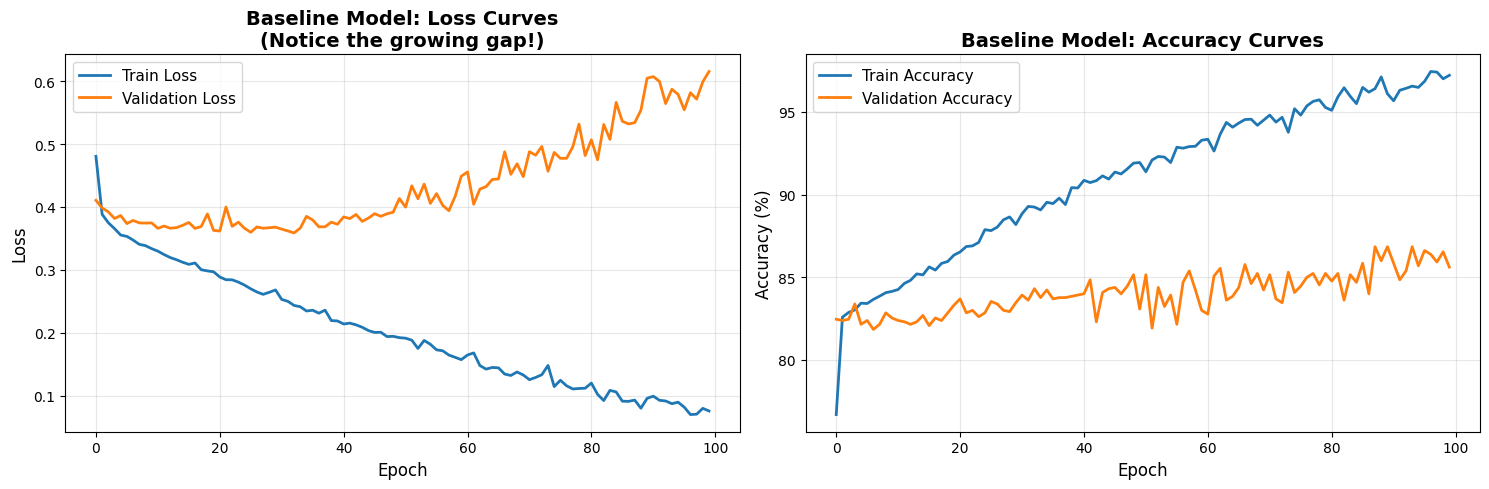

In [10]:
# Visualize baseline performance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(baseline_train_losses, label='Train Loss', linewidth=2)
axes[0].plot(baseline_val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Baseline Model: Loss Curves\n(Notice the growing gap!)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(baseline_val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Baseline Model: Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

> **The overfitting signature**: Watch the divergence: training loss drops from 0.33 to 0.07 while validation loss rises from 0.37 to 0.61. Training accuracy climbs to ~97% while validation stalls at ~86%. 
> 
> This growing gap is the hallmark of overfitting: the model is memorizing training examples (achieving near-perfect performance) rather than learning generalizable patterns, which is exactly what we want to fix with regularization.

## Step 5: Add dropout regularization

Now let's fight back against overfitting with dropout. Dropout randomly "turns off" a percentage of neurons during training, forcing the network to learn robust, redundant features instead of memorizing specific training examples.

In [11]:
# Model WITH dropout
class ModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(ModelWithDropout, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))  # Add dropout!
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Add dropout after each hidden layer!
        
        # Output layer (no dropout here)
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create model with dropout
dropout_model = ModelWithDropout(input_size, hidden_sizes, output_size, dropout_rate=0.3).to(device)
print("✓ Model with dropout created")
print(f"  Architecture: {input_size} → 128 (+dropout) → 64 (+dropout) → 32 (+dropout) → {output_size}")
print(f"  Dropout rate: 30% of neurons randomly disabled during training")

✓ Model with dropout created
  Architecture: 12 → 128 (+dropout) → 64 (+dropout) → 32 (+dropout) → 1
  Dropout rate: 30% of neurons randomly disabled during training


> **Dropout placement strategy**: We add dropout after each ReLU activation, not before. Why? ReLU zeros out negative values, and dropout zeros out random activations—applying dropout first would compound these effects unnecessarily. We also skip dropout on the output layer because we want deterministic final predictions. 
> 
> The pattern: `Linear → Activation → Dropout → Next Layer` is the standard architecture for regularized networks.

### Demonstrating dropout in action

Let's see dropout's randomness in action. We'll pass the same input through the network twice, in training mode and evaluation mode, and explore outputs.

> <details><summary><b>Do you expect the outputs at training time to be the same or different? What about at evaluation time?</b></summary>
> 
> - At training time, outputs will be **different** each pass! Dropout randomly drops different neurons (30% of them), so the active computation path changes. This randomness forces every neuron to learn useful features independently—no neuron can rely on specific partners always being there. 
> 
> - At evaluation time, outputs become **identical**: all neurons are active and dropout is disabled, giving deterministic predictions. This is why you must call `model.eval()` before making predictions.
> </details>

In [12]:
# Demonstrate dropout randomness
dropout_model.train()  # Enable training mode (dropout is active)

# Get a sample input
sample_input = train_dataset[0][0].unsqueeze(0).to(device)

# Run the same input through the network three times
with torch.no_grad():
    output1 = dropout_model(sample_input).item()
    output2 = dropout_model(sample_input).item()
    output3 = dropout_model(sample_input).item()

print("Same input, three forward passes in TRAIN mode (dropout active):")
print(f"  Pass 1: {output1:.6f}")
print(f"  Pass 2: {output2:.6f}")
print(f"  Pass 3: {output3:.6f}")
print(f"  → Outputs differ because different neurons are dropped each time!\n")

# Now try in eval mode
dropout_model.eval()  # Disable dropout

with torch.no_grad():
    output1 = dropout_model(sample_input).item()
    output2 = dropout_model(sample_input).item()
    output3 = dropout_model(sample_input).item()

print("Same input, three forward passes in EVAL mode (dropout disabled):")
print(f"  Pass 1: {output1:.6f}")
print(f"  Pass 2: {output2:.6f}")
print(f"  Pass 3: {output3:.6f}")
print(f"  → Outputs are identical because all neurons are active!")

Same input, three forward passes in TRAIN mode (dropout active):
  Pass 1: -0.023901
  Pass 2: 0.005386
  Pass 3: -0.091299
  → Outputs differ because different neurons are dropped each time!

Same input, three forward passes in EVAL mode (dropout disabled):
  Pass 1: -0.036010
  Pass 2: -0.036010
  Pass 3: -0.036010
  → Outputs are identical because all neurons are active!


> **Training vs. evaluation mode**: This is crucial! 
> - During training (`model.train()`), dropout randomly disables neurons to prevent overfitting.
> - During evaluation (`model.eval()`), dropout is automatically disabled so all neurons contribute to predictions. 
> 
> This is why you must always call `model.eval()` before making predictions, otherwise your outputs will be inconsistent and artificially lowered.

In [13]:
# Train model with dropout
print("Training model WITH dropout...\n")

dropout_optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)

dropout_train_losses, dropout_val_losses, dropout_train_accs, dropout_val_accs = train_model(
    dropout_model, train_loader, val_loader, dropout_optimizer, criterion,
    epochs=epochs, model_name="Dropout"
)

print(f"\n✓ Dropout model training complete!")
print(f"  Final train accuracy: {dropout_train_accs[-1]:.2f}%")
print(f"  Final validation accuracy: {dropout_val_accs[-1]:.2f}%")
print(f"  Gap: {dropout_train_accs[-1] - dropout_val_accs[-1]:.2f}%")

Training model WITH dropout...

Epoch 10/100 | Train Loss: 0.3596 | Val Loss: 0.3764 | Train Acc: 83.45% | Val Acc: 82.62% | LR: 0.001000
Epoch 20/100 | Train Loss: 0.3414 | Val Loss: 0.3683 | Train Acc: 83.89% | Val Acc: 82.38% | LR: 0.001000
Epoch 30/100 | Train Loss: 0.3274 | Val Loss: 0.3649 | Train Acc: 84.66% | Val Acc: 82.62% | LR: 0.001000
Epoch 40/100 | Train Loss: 0.3220 | Val Loss: 0.3611 | Train Acc: 84.97% | Val Acc: 83.31% | LR: 0.001000
Epoch 50/100 | Train Loss: 0.3112 | Val Loss: 0.3612 | Train Acc: 85.91% | Val Acc: 83.46% | LR: 0.001000
Epoch 60/100 | Train Loss: 0.2992 | Val Loss: 0.3609 | Train Acc: 86.57% | Val Acc: 84.08% | LR: 0.001000
Epoch 70/100 | Train Loss: 0.2906 | Val Loss: 0.3535 | Train Acc: 86.82% | Val Acc: 84.46% | LR: 0.001000
Epoch 80/100 | Train Loss: 0.2918 | Val Loss: 0.3563 | Train Acc: 87.01% | Val Acc: 84.85% | LR: 0.001000
Epoch 90/100 | Train Loss: 0.2798 | Val Loss: 0.3485 | Train Acc: 87.55% | Val Acc: 84.69% | LR: 0.001000
Epoch 100/100 

> **The regularization payoff**: Training accuracy dropped from ~97% to ~88%, but the train-val gap collapsed from 11.59% to 3.94%. This tight coupling means we could now safely train for 200+ epochs to squeeze out more performance, whereas the baseline was already overfitting after a few epochs. 
> 
> Dropout transformed a memorizing model into one that learns generalizable patterns, unlocking the ability to train longer without degradation.

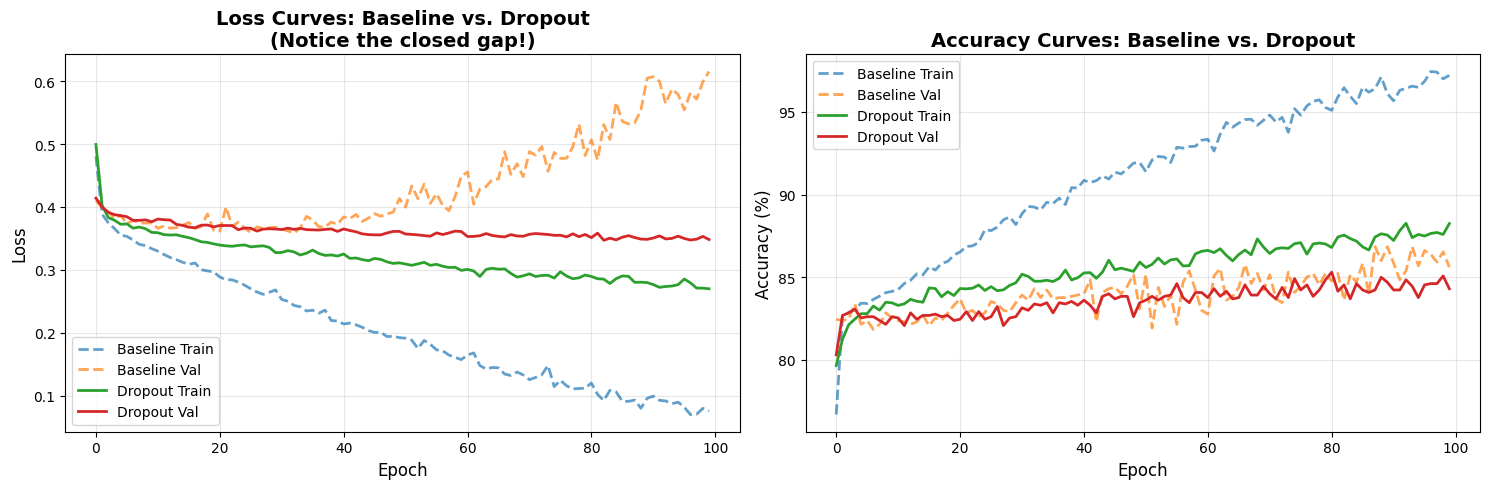

In [14]:
# Compare baseline vs. dropout
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss comparison
axes[0].plot(baseline_train_losses, label='Baseline Train', linewidth=2, linestyle='--', alpha=0.7)
axes[0].plot(baseline_val_losses, label='Baseline Val', linewidth=2, linestyle='--', alpha=0.7)
axes[0].plot(dropout_train_losses, label='Dropout Train', linewidth=2)
axes[0].plot(dropout_val_losses, label='Dropout Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Curves: Baseline vs. Dropout\n(Notice the closed gap!)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(baseline_train_accs, label='Baseline Train', linewidth=2, linestyle='--', alpha=0.7)
axes[1].plot(baseline_val_accs, label='Baseline Val', linewidth=2, linestyle='--', alpha=0.7)
axes[1].plot(dropout_train_accs, label='Dropout Train', linewidth=2)
axes[1].plot(dropout_val_accs, label='Dropout Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Curves: Baseline vs. Dropout', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dropout_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

> **The closed gap tells the story**: Dropout's train-val gap stays tight-3.9% in accuracy, 0.08 in loss at epoch 100. Even more impressive: the gap doesn't widen over time, suggesting we could train even longer without degradation. 
> 
> This is regularization working exactly as intended.

## Step 6: Add learning rate scheduling for better convergence

Dropout helped a lot, but we can do even better! Learning rate scheduling gradually reduces the learning rate during training: start with large steps for rapid exploration, then shrink to tiny steps for precise fine-tuning. This helps the model converge to a better final solution.

In [15]:
# Create model with dropout AND learning rate scheduling
scheduled_model = ModelWithDropout(input_size, hidden_sizes, output_size, dropout_rate=0.3).to(device)
scheduled_optimizer = optim.Adam(scheduled_model.parameters(), lr=0.001)

# Add learning rate scheduler: reduce LR by 0.5 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(scheduled_optimizer, step_size=15, gamma=0.5)

print("✓ Model with dropout + LR scheduling created")
print(f"  Starting learning rate: {scheduled_optimizer.param_groups[0]['lr']}")
print(f"  LR will decay by 0.5× every 15 epochs")
print(f"  Example: 0.001 → 0.0005 (epoch 15) → 0.00025 (epoch 30) → 0.000125 (epoch 45)")

✓ Model with dropout + LR scheduling created
  Starting learning rate: 0.001
  LR will decay by 0.5× every 15 epochs
  Example: 0.001 → 0.0005 (epoch 15) → 0.00025 (epoch 30) → 0.000125 (epoch 45)


> **Choosing StepLR**: Among PyTorch's many schedulers ([docs](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)), we use `StepLR` for its simplicity. With StepLR, learning rate drops by 50% (`gamma`) every 15 (`step_size`) epochs. This creates distinct training phases that make the scheduling effect easy to see. 
> 
> Alternatives like `CosineAnnealingLR` (smooth decay) or `ReduceLROnPlateau` (adaptive) can work better for specific problems, but StepLR is a solid starting point.

In [16]:
# Train with dropout + scheduling
print("\nTraining model WITH dropout + LR scheduling...\n")

scheduled_train_losses, scheduled_val_losses, scheduled_train_accs, scheduled_val_accs = train_model(
    scheduled_model, train_loader, val_loader, scheduled_optimizer, criterion,
    epochs=epochs, scheduler=scheduler, model_name="Dropout+Scheduling"
)

print(f"\n✓ Scheduled model training complete!")
print(f"  Final train accuracy: {scheduled_train_accs[-1]:.2f}%")
print(f"  Final validation accuracy: {scheduled_val_accs[-1]:.2f}%")
print(f"  Gap: {scheduled_train_accs[-1] - scheduled_val_accs[-1]:.2f}%")


Training model WITH dropout + LR scheduling...

Epoch 10/100 | Train Loss: 0.3608 | Val Loss: 0.3761 | Train Acc: 83.64% | Val Acc: 81.92% | LR: 0.001000
Epoch 20/100 | Train Loss: 0.3418 | Val Loss: 0.3698 | Train Acc: 84.07% | Val Acc: 82.23% | LR: 0.000500
Epoch 30/100 | Train Loss: 0.3492 | Val Loss: 0.3699 | Train Acc: 84.05% | Val Acc: 82.15% | LR: 0.000250
Epoch 40/100 | Train Loss: 0.3326 | Val Loss: 0.3689 | Train Acc: 84.66% | Val Acc: 82.38% | LR: 0.000250
Epoch 50/100 | Train Loss: 0.3268 | Val Loss: 0.3670 | Train Acc: 85.28% | Val Acc: 82.62% | LR: 0.000125
Epoch 60/100 | Train Loss: 0.3236 | Val Loss: 0.3656 | Train Acc: 85.34% | Val Acc: 82.31% | LR: 0.000063
Epoch 70/100 | Train Loss: 0.3255 | Val Loss: 0.3651 | Train Acc: 84.82% | Val Acc: 82.62% | LR: 0.000063
Epoch 80/100 | Train Loss: 0.3249 | Val Loss: 0.3647 | Train Acc: 85.43% | Val Acc: 82.46% | LR: 0.000031
Epoch 90/100 | Train Loss: 0.3206 | Val Loss: 0.3645 | Train Acc: 85.09% | Val Acc: 82.46% | LR: 0.0000

> **The regularization balancing act**: With respect to only using dropout, adding scheduling reduced the training–validation loss gap from 3.94% to 2.74%, but actually worsened validation accuracy from 84.31% to 82.54%. What does that tell us?
> - The scheduler settings are probably too aggressive and need tuning.
> - But more importantly: the model might not need extra regularization at all. With dropout alone, the gap was already small (3.94%), suggesting the model wasn’t overfitting much. Adding more regularization on top can actually hurt learning.
> - In contrast, if the gap were large (e.g., 10%), then adding techniques like scheduling would make sense.
> 
> *Bottom line*: Only add complexity when it solves a real problem. If the model is already well-behaved, extra regularization may do more harm than good.

## Conclusion
Congratulations! You've just witnessed how dropout and learning rate scheduling can transform an overfitting model into one that generalizes to new data. 

**What you've learned:**

- [x] **Dropout mechanics** - randomly disabling neurons during training forces the network to learn robust, redundant features
- [x] **Training vs. evaluation mode** - dropout only activates during training; always call `model.eval()` before making predictions
- [x] **Learning rate scheduling** - starting with large steps and gradually reducing enables both fast initial learning and precise final convergence
- [x] **The regularization trade-off** - lower training performance with better generalization means the model learned patterns, not noise
- [x] **Tuning matters** - stacking techniques requires careful hyperparameter adjustment; over-regularization is a real risk

> **Key insight**: Regularization doesn't make your model smarter; it makes your model more honest. Dropout forced the network to learn features that work even when neurons randomly disappear, and learning rate scheduling can further help it settle into better solutions. The train-validation gap is your diagnostic tool: a wide gap signals overfitting that regularization can fix, while a narrow gap with strong validation performance means your model has learned generalizable patterns. When stacking techniques, always optimize for validation performance, not just gap size: sometimes one well-tuned regularization method beats multiple poorly-tuned ones. The goal is a model you can trust in production, not perfect training metrics.

##### Next steps to explore:

- [ ] **What happens with different dropout rates?** Try 0.1, 0.2, 0.4, 0.5—is there a sweet spot where regularization is strongest without underfitting?
- [ ] **Can better scheduling recover performance?** Experiment with gentler decay (`step_size=25, gamma=0.7`) or try `CosineAnnealingLR` to see if dropout + scheduling can beat dropout alone
- [ ] **What about weight decay?** Add `weight_decay=1e-4` to your optimizer for an additional regularization layer. Does it combine well with dropout?
- [ ] **How would less data change things?** Train on only 50% of the dataset. Soes dropout become even more critical when data is scarce?